# Лабораторная работа 2. Методы обучения нейронных сетей

### Содержание
1. [Работа с данными](#Работа-с-данными)
1. [Построение модели](#Построение-модели)
1. [Исследование гиперпараметров](#Исследование-гиперпараметров)

В данной лабораторной работе потребуется исследовать эффективность различных приемов и методов обучения нейронных сетей:
* количество нейронов скрытого слоя;
* количество эпох обучения;
* функции активации;
* регуляризация;
* инициализация весов;
* нормализация по мини-батчам;
* методы градиентного спуска;
* адаптивные методы градиентного спуска.

### Работа с данными

Исследовать эти приемы и методы предлагается на [MNIST](http://yann.lecun.com/exdb/mnist/) (Modified National Institute of Standards and Technology) – наборе черно-белых рукописных цифр размером 28x28 пикселей:

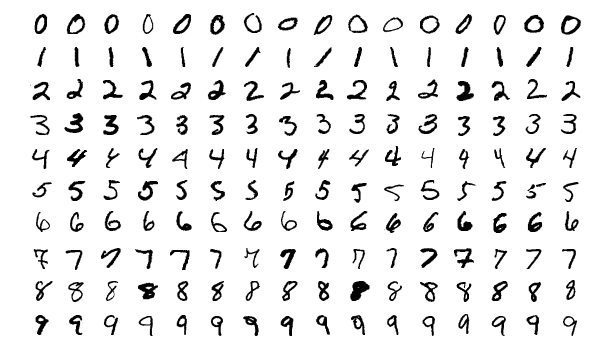

MNIST содержит 60 000 изображений для обучения и 10 000 изображений для тестирования.

In [1]:
import torch
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
from time import time

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
torch.manual_seed(42)

---
Задаем гиперпараметры (некоторые из них нужно будет менять в процессе исследования):

In [4]:
input_size = 28 * 28 # 784
hidden_size = 500
num_classes = 10
num_epochs = 5
batch_size = 100
learning_rate = 0.001

---
Код работы с данными (загрузка, предобработка, сэмплирование) должен быть отделен от кода работы с моделями (создание, обучение, тестирование).  
PyTorch предоставляет два класса для работы с данными: `Dataset` и `DataLoader`:  
- класс [Dataset](https://pytorch.org/docs/stable/data.html#torch.utils.data.Dataset) позволяет загружать и хранить как предустановленные наборы данных (например, MNIST), так и свои собственные;
- класс [DataLoader](https://pytorch.org/docs/stable/data.html#torch.utils.data.DataLoader) позволяет осуществлять доступ к данным в процессе обучения.  

В PyTorch есть множество предустановленных наборов данных:
- [текстов](https://pytorch.org/text/stable/datasets.html);
- [изображений](https://pytorch.org/vision/stable/datasets.html);
- [аудио](https://pytorch.org/audio/stable/datasets.html).

Ниже приведен код загрузки MNIST:

In [5]:
train_dataset = torchvision.datasets.MNIST(root='data', 
                                           train=True, 
                                           transform=transforms.ToTensor(),  
                                           download=True)
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [6]:
test_dataset = torchvision.datasets.MNIST(root='data', 
                                          train=False, 
                                          transform=transforms.ToTensor())
test_dataset

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

---
Список всех классов в `Dataset`:

In [7]:
train_dataset.classes

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

К примерам в `Dataset` можно обращаться по индексу. Выведем, например, метку самого первого примера:

In [8]:
print(f'Label of the first example is {train_dataset[0][1]}.')

Label of the first example is 5.


---
Цифры можно нарисовать:

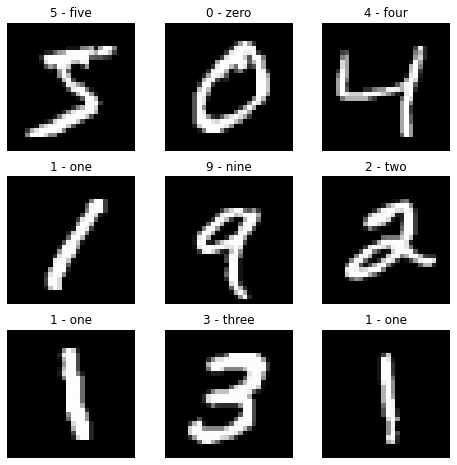

In [9]:
figure = plt.figure(figsize=(8, 8))
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    img, label = train_dataset[i-1]
    figure.add_subplot(rows, cols, i)
    plt.title(train_dataset.classes[label])
    plt.axis("off")
    plt.imshow(img.squeeze(), cmap="gray")
plt.show()

При загрузке мы применили [преобразование данных](https://pytorch.org/tutorials/beginner/basics/transforms_tutorial.html): `transform=transforms.ToTensor()` осуществляет преобразование чисел в тензоры и нормирует к диапазону [0, 1].  
Также можно применять преобразования к меткам (например, переводить индекс в *OneHot Encoding*), для этого служит параметр `target_transform`.

---
#### Терминология  
- *Батч (batch)* – подмножество обучающих данных, которое подается на сеть в процессе обучения. после чего веса сети обновляются.  
    - `batch_size = len(train_dataset)` – Vanilla Gradient Descent или Batch Gradient Descent
    - `batch_size = 1` – Stochastic Gradient Descent
    - `1 < batch_size < len(train_dataset)` – Mini-Batch Gradient Descent
- *Шаг (step)* – период обработки одного батча.  
- *Эпоха (epoch)* – период обработки всего обучающего множества; количество шагов в эпохе равно количеству батчей в обучающем множестве. 

---
Для подготовки данных для обучения служит класс `DataLoader`. Он позволяет случайным образом формировать мини-батчи и перемешивать данные перед каждой эпохой обучения.  
Зададим объекты `DataLoader` на основе MNIST:

In [10]:
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, 
                                           batch_size=batch_size, 
                                           shuffle=True)

In [11]:
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, 
                                          batch_size=batch_size, 
                                          shuffle=False)

---
По объектам `DataLoader` можно осуществлять итерацию; при этом на каждом шаге будет возвращаться подмножество размером `batch_size`:

In [12]:
print(f'Number of batches = {len(train_loader)}')

train_data, train_labels = next(iter(train_loader))
print(f'Size of the batch = {len(train_data)}')

print(f'Number of all the samples = {len(train_loader) * len(train_data)}')

Number of batches = 600
Size of the batch = 100
Number of all the samples = 60000


После того, как все батчи будут выданы (по окончании эпохи обучения), в случае, если `shuffle=True`, произойдет перемешивание данных и на следующей эпохе батчи будут уже другими.

### Построение модели

#### Задание.  
Опишите класс `NeuralNetwork` для распознавания MNIST: двухслойная нейронная сеть прямого распространения, количество нейронов скрытого слоя – `hidden_size`, функция активации скрытого слоя – `ReLU`. Выходной слой пусть остается линейным, без функции активации.

In [13]:
class NeuralNetwork(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork, self).__init__()                    
        self.hidden = nn.Linear(input_size, hidden_size)                        
        self.output = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):   
        relu = nn.ReLU()                              
        x = relu(self.hidden(x))
        y = self.output(x)
        return y

#### Задание.  
Создайте объект класса `NeuralNetwork`, перенесите его на GPU.  
Задайте функцию потерь (например, `CrossEntropyLoss`) и любой оптимизатор.

In [14]:
model = NeuralNetwork(input_size, hidden_size, num_classes)
model.cuda()

NeuralNetwork(
  (hidden): Linear(in_features=784, out_features=500, bias=True)
  (output): Linear(in_features=500, out_features=10, bias=True)
)

In [15]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate)
optimizer

SGD (
Parameter Group 0
    dampening: 0
    lr: 0.001
    momentum: 0
    nesterov: False
    weight_decay: 0
)

input_size = 28 * 28 # 784

hidden_size = 500

num_classes = 10

num_epochs = 5

batch_size = 100

learning_rate = 0.001

---
Напишем цикл обучения для нашей сети:

In [16]:
loss_results = []

In [17]:

start_time = time()

total_step = len(train_loader)
for epoch in range(num_epochs):
    for i, (images, labels) in enumerate(train_loader):  
        # Move tensors to the configured device
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        
        # Forward pass
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        
        # Backward and optimize
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 100 == 0:
            print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
            loss_results.append(loss.item())
print(f'Time = {time() - start_time:.1f}')

Epoch [1/5], Step [100/600], Loss: 2.2943
Epoch [1/5], Step [200/600], Loss: 2.2720
Epoch [1/5], Step [300/600], Loss: 2.2414
Epoch [1/5], Step [400/600], Loss: 2.2039
Epoch [1/5], Step [500/600], Loss: 2.2027
Epoch [1/5], Step [600/600], Loss: 2.1833
Epoch [2/5], Step [100/600], Loss: 2.1445
Epoch [2/5], Step [200/600], Loss: 2.1272
Epoch [2/5], Step [300/600], Loss: 2.1033
Epoch [2/5], Step [400/600], Loss: 2.0609
Epoch [2/5], Step [500/600], Loss: 2.0581
Epoch [2/5], Step [600/600], Loss: 2.0064
Epoch [3/5], Step [100/600], Loss: 2.0209
Epoch [3/5], Step [200/600], Loss: 1.9584
Epoch [3/5], Step [300/600], Loss: 1.9267
Epoch [3/5], Step [400/600], Loss: 1.8841
Epoch [3/5], Step [500/600], Loss: 1.8205
Epoch [3/5], Step [600/600], Loss: 1.8370
Epoch [4/5], Step [100/600], Loss: 1.7628
Epoch [4/5], Step [200/600], Loss: 1.7945
Epoch [4/5], Step [300/600], Loss: 1.7172
Epoch [4/5], Step [400/600], Loss: 1.6899
Epoch [4/5], Step [500/600], Loss: 1.7174
Epoch [4/5], Step [600/600], Loss:

#### Задание.  
Постройте график зависимости потерь на мини-батче от шага обучения.

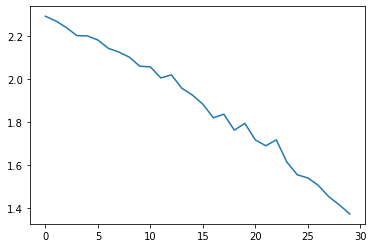

In [18]:
import numpy as np
plt.plot(np.arange(30), loss_results)

---
Получим предсказания модели на тестовых данных:

In [19]:
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)

print(f'last predict = {predicted[-1]}, true label = {labels[-1]}')

last predict = 6, true label = 6


#### Задание.  
Вычислите правильность (Accuracy) модели на тестовых данных.

In [20]:
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images = images.reshape(-1, 28*28).to(device)
        labels = labels.to(device)
        outputs = model(images)
        max_values, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

print(f'Accuracy = {100*correct/total}')

Accuracy = 78.06


---
Сохраним полученную модель:

In [21]:
torch.save(model.state_dict(), 'model.ckpt')

### Исследование гиперпараметров

#### Задание. 

Подберите гиперпараметры нейронной сети, обеспечивающие наилучшее качество классификации тестовых данных MNIST.  
Требуется исследовать следующие гиперпараметры:
* количество нейронов скрытого слоя – не менее 5 вариантов;
* количество эпох обучения – не менее 3 вариантов;
* функции активации – не менее 3 вариантов (симметричные и несимметричные);
* регуляризация – weight decay (L2) и dropout;
* инициализация весов (Xavier и Kaiming);
* нормализация по мини-батчам (наличие/отсутствие);
* методы градиентного спуска (SGD, momentum SGD, Nesterov SGD);
* адаптивные методы градиентного спуска (AdaGrad, AdaDelta, RMSProp, Adam, AdamW).

In [ ]:
switch_model_list = [
    'None', 'Batch', 'Activated', 'DO', 'Weights']
activate_func = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}
hidden_size_list = [100, 200, 500, 1000, 2000]
Accuracy = 0
function = 'None'
weight_init = ['Xavier', 'None', 'Kaiming']
epoch_value_list = [5, 7, 9]
switch_optimizer = ['NSGD', 'AG', 'RMSProp']
weight_decay = [False, True]

Необязательно выполнять полный перебор – можно осуществить жадный поиск.  

Результаты подбора вывести в удобном виде.  

Для всех вариантов градиентного спуска нарисовать графики процесса обучения.  


In [15]:
class NeuralNetwork_weights(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_batch, self).__init__()                    
        self.hidden = nn.Linear(input_size, hidden_size)   
        self.output = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):   
        y = activation(self.hidden(x))
        y = self.output(x)
        return y

In [16]:
class NeuralNetwork_activate(nn.Module):
    def __init__(self):
        super(NeuralNetwork_activate, self).__init__()                    
        self.hidden = nn.Linear(input_size, hidden_size)   
        self.output = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):   
        y = activation(self.hidden(x))
        y = self.output(y)
        return y

In [17]:
class NeuralNetwork_drop(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_drop, self).__init__()                    
        self.hidden = nn.Linear(input_size, hidden_size)     
        self.dropout = nn.Dropout(0.2)            
        self.output = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):   
        x = self.hidden(x)
        x = torch.relu(x)
        x = self.dropout(x)
        x = self.output(x)
        return x

In [18]:
class NeuralNetwork_batch(nn.Module):
    def __init__(self, input_size, hidden_size, num_classes):
        super(NeuralNetwork_batch, self).__init__()                    
        self.hidden = nn.Linear(input_size, hidden_size)   
        self.bn = nn.BatchNorm1d(num_features = hidden_size)                 
        self.output = nn.Linear(hidden_size, num_classes) 
    
    def forward(self, x):   
        relu = nn.ReLU()                           
        x = relu(self.bn(self.hidden(x)))
        y = self.output(x)
        return y

In [19]:
def get_optimizer(name, weig, model):
    if name == 'SGD':
        if weig:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate, 
                weight_decay = 0.001)
        else:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate)
    elif name == 'MSGD':
        if weig:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate, 
                momentum = 0.9, weight_decay = 0.001)
        else:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate, momentum = 0.9)
    elif name == 'NSGD':
        if weig:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate, 
                nesterov = True, weight_decay = 0.001,
                momentum = 0.9
                )
        else:
            optimizer = torch.optim.SGD(
                model.parameters(), lr = learning_rate, 
                nesterov = True, weight_decay = 0,
                momentum = 0.9)
    elif name == 'AG':
        if weig:
            optimizer = torch.optim.Adagrad(
                model.parameters(), lr = learning_rate,
                weight_decay = 0.001)
        else:
            optimizer = torch.optim.Adagrad(
                model.parameters(), lr = learning_rate)
    elif name == 'Adam':
        if weig:
            optimizer = torch.optim.Adam(
                model.parameters(), lr = learning_rate,
                weight_decay = 0.001)
        else:
            optimizer = torch.optim.Adam(
                model.parameters(), lr = learning_rate)
    elif name == 'RMSProp':
        if weig:
            optimizer = torch.optim.RMSprop(
                model.parameters(), lr=learning_rate,
                weight_decay = 0.001)
        else:
            optimizer = torch.optim.RMSprop(
                model.parameters(), lr=learning_rate)

    return optimizer

In [20]:
def switch_model(name_model, h):
    if name_model == 'Batch':
        model = NeuralNetwork_batch(input_size, h, num_classes)
    elif name_model == 'DO':
        model = NeuralNetwork_drop(input_size, h, num_classes)
    else:
        model = NeuralNetwork(input_size, h, num_classes)
    model.cuda()

    return model

In [21]:
def init_weights(m):
    if type(m) == nn.Linear:
        if function == 'Xavier':
            torch.nn.init.xavier_uniform_(
                m.weight, gain = 1.0)
        elif function == 'Kaiming':
            torch.nn.init.kaiming_uniform_(
                m.weight, a = 0, mode = 'fan_in',
                nonlinearity = 'leaky_relu')
        
        m.bias.data.fill_(0.01)

In [22]:
def Accuracy_value(model):
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in test_loader:
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)
            outputs = model(images)
            max_values, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct/total

In [23]:
def continue_learning(m, name, h, acc):
    weight_init = ['Xavier', 'None', 'Kaiming']
    epoch_value_list = [3, 5]
    switch_optimizer = ['NSGD', 'AG', 'RMSProp']
    weight_decay = [False, True]
    model = m
    loss_fn = nn.CrossEntropyLoss()

    for init_type in weight_init:
        if init_type == 'Xavier' or init_type == 'Kaiming':
            function = init_type
            model.apply(init_weights)

        for weig in weight_decay:
            for op in switch_optimizer:
                optimizer = get_optimizer(op, weig, model)
                total_step = len(train_loader)
                for j in epoch_value_list:
                    num_epochs = j
                    loss_at_epoch = []
                    for epoch in range(num_epochs):
                        pbar.update(1)
                        for i, (images, labels) in enumerate(train_loader):  
                            images = images.reshape(-1, 28*28).to(device)
                            labels = labels.to(device)

                            outputs = model(images)
                            loss = loss_fn(outputs, labels)
                            optimizer.zero_grad()
                            loss.backward()
                            optimizer.step()

                            if (i+1) % 100 == 0:
                                #print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
                                loss_at_epoch.append(loss.item())                                

                        if(acc < Accuracy_value(model)):
                            model_name = name
                            acc = Accuracy_value(model)
                            hs_res = h
                            epoch_res = j
                            optimizer_res = op
                            weight_decay_res = weig
                            init_type_res = init_type

                            print("Update value of best Accuracy")
                            print(f"At model - {model_name} Accuracy = {acc}")
                            print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}, Optimizer = {optimizer_res}")
                            print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")

                        loss_results.append(loss_at_epoch)

In [24]:
def learning(h, weig, op, j, Accuracy, model, name): 
    loss_fn = nn.CrossEntropyLoss()
    optimizer = get_optimizer(op, weig, model)
    num_epochs = j
    loss_at_epoch = []
    pbar.update(1)
    for epoch in range(num_epochs):
        for i, (images, labels) in enumerate(train_loader):
            images = images.reshape(-1, 28*28).to(device)
            labels = labels.to(device)

            outputs = model(images)
            loss = loss_fn(outputs, labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (i+1) % 100 == 0:
            #print(f'Epoch [{epoch+1}/{num_epochs}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
                loss_at_epoch.append(loss.item())                                
    return Accuracy_value(model)

In [17]:
#hidden_size_list = [20, 40, 60, 80, 100]
hidden_size_list = [100]
epoch_value_list = [3, 5]
#opt_lower = ['NSGD', 'SGD', 'MSGD', 'AG', 'Adam', 'RMSProp'] #  - ValueError: Nesterov momentum requires a momentum and zero dampening
opt_lower = ['NSGD', 'AG', 'RMSProp'] #  - ValueError: Nesterov momentum requires a momentum and zero dampening
reg_lu_list = ['None', 'WD', 'DO'] 
mini_batch = [False, True] 
weight_decay = [False, True]
drop_out = [False, True]
weight_init = ['None', 'Xavier', 'Kaiming']
activate_func = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}

Accuracy = 0
epoch_res = 0
hs_res = 0
optimizer_res = ''
mini_batch_res = False
weight_decay_res = False
drop_out_res = False

loss_results = []

# Определение лучших параметров

In [25]:
import time
from tqdm import tqdm
from tqdm import tnrange

switch_model_list = [
    'None', 'Batch', 'Activated', 'DO', 'Weights']
activate_func = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}
hidden_size_list = [100, 200, 500, 1000, 2000]
Accuracy = 0
function = 'None'
weight_init = ['Xavier', 'None', 'Kaiming']
epoch_value_list = [5, 7, 9]
switch_optimizer = ['MSGD', 'Adam', 'RMSProp']
weight_decay = [False, True]

Accuracy_chek = -1
pbar = tqdm(total = 1890)

for h in hidden_size_list:
    for m in switch_model_list:
        for init_type in weight_init:
            for weig in weight_decay:
                for op in switch_optimizer:
                    total_step = len(train_loader)
                    for j in epoch_value_list:
                        if m != 'Activated':
                            model = switch_model(m, h)
                            if init_type == 'Xavier' or init_type == 'Kaiming':
                                function = init_type
                                model.apply(init_weights)

                            Accuracy_chek = learning(h, weig, op, j, Accuracy, model, m)
                            
                            if(Accuracy < Accuracy_chek):
                                model_name = m
                                Accuracy = Accuracy_value(model)
                                hs_res = h
                                epoch_res = j
                                optimizer_res = op
                                weight_decay_res = weig
                                init_type_res = init_type

                                print("Update value of best Accuracy")
                                print(f"At model - {model_name} ; Accuracy = {Accuracy}")
                                print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}, Optimizer = {optimizer_res}")
                                print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")
                        else:
                            for a in range(len(activate_func)):
                                activation = list(activate_func.values())[a]
                                model = NeuralNetwork_activate()
                                model.cuda()
                                
                                if init_type == 'Xavier' or init_type == 'Kaiming':
                                    function = init_type
                                    model.apply(init_weights) 
                                Accuracy_chek = learning(h, weig, op, j, Accuracy, model, m)   
                                
                                if(Accuracy < Accuracy_chek):
                                    model_name = m
                                    Accuracy = Accuracy_value(model)
                                    hs_res = h
                                    epoch_res = j
                                    optimizer_res = op
                                    weight_decay_res = weig
                                    init_type_res = init_type

                                    print("Update value of best Accuracy")
                                    print(f"At model - {model_name} Function activated - {list(activate_func)[a]}; Accuracy = {Accuracy}")
                                    print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}, Optimizer = {optimizer_res}")
                                    print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")                     
pbar.close()

  0%|          | 2/1890 [00:21<6:32:16, 12.47s/it]Update value of best Accuracy
At model - None ; Accuracy = 91.5
With paramentres: Hidden_size = 100, Epoch  = 5, Optimizer = MSGD
Weight decay = False, init type for weights = Xavier

  0%|          | 3/1890 [00:48<10:10:51, 19.42s/it]Update value of best Accuracy
At model - None ; Accuracy = 91.97
With paramentres: Hidden_size = 100, Epoch  = 7, Optimizer = MSGD
Weight decay = False, init type for weights = Xavier

  0%|          | 4/1890 [01:24<13:28:03, 25.71s/it]Update value of best Accuracy
At model - None ; Accuracy = 92.78
With paramentres: Hidden_size = 100, Epoch  = 9, Optimizer = MSGD
Weight decay = False, init type for weights = Xavier

  0%|          | 5/1890 [01:44<12:25:09, 23.72s/it]Update value of best Accuracy
At model - None ; Accuracy = 97.3
With paramentres: Hidden_size = 100, Epoch  = 5, Optimizer = Adam
Weight decay = False, init type for weights = Xavier

  0%|          | 6/1890 [02:12<13:11:40, 25.21s/it]Update v

In [27]:
print("Update value of best Accuracy")
print(f"At model - {model_name}; Accuracy = {Accuracy}")
print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}, Optimizer = {optimizer_res}")
print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")  

Update value of best Accuracy
At model - None; Accuracy = 98.42
With paramentres: Hidden_size = 1000, Epoch  = 9, Optimizer = Adam
Weight decay = False, init type for weights = Xavier



# The best structure for solving the problem:
## Hidden size = 1000, Epoch value = 9, Optimizer = Adam
## Weight decay = False, Init type for weights = Xavier

# Результаты Drop out на разных функциях активации

## Drop Out on Sigmoid = 95.09

## Drop Out on Relu = 96.53

## Drop Out on Tanh = 95.89

In [32]:
def best_params(op):
    print(switch_optimizer)
    switch_model_list = [
        'None', 'Batch', 'Activated', 'DO', 'Weights']
    activate_func = {'relu': torch.relu, 'tanh': torch.tanh, 'sigmoid': torch.sigmoid}
    hidden_size_list = [500, 1000]
    Accuracy = 0
    function = 'None'
    weight_init = ['Xavier', 'None', 'Kaiming']
    epoch_value_list = [7, 9]
    weight_decay = [False, True]

    Accuracy_chek = -1
    pbar = tqdm(total = 252)

    for h in hidden_size_list:
        for m in switch_model_list:
            for init_type in weight_init:
                for weig in weight_decay:
                    total_step = len(train_loader)
                    for j in epoch_value_list:
                        if m != 'Activated':
                            model = switch_model(m, h)
                            if init_type == 'Xavier' or init_type == 'Kaiming':
                                function = init_type
                                model.apply(init_weights)

                            Accuracy_chek = learning(h, weig, op, j, Accuracy, model, m)
                                
                            if(Accuracy < Accuracy_chek):
                                model_name = m
                                Accuracy = Accuracy_value(model)
                                hs_res = h
                                epoch_res = j
                                optimizer_res = op
                                weight_decay_res = weig
                                init_type_res = init_type
                                
                                print("Upd best Accuracy")
                                print(f"Best params for {op}, with accuracy {Accuracy}")
                                print(f"Model - {model_name};")
                                print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}")
                                print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")   
                        else:
                            for a in range(len(activate_func)):
                                activation = list(activate_func.values())[a]
                                model = NeuralNetwork_activate()
                                model.cuda()
                                    
                                if init_type == 'Xavier' or init_type == 'Kaiming':
                                    function = init_type
                                    model.apply(init_weights) 
                                Accuracy_chek = learning(h, weig, op, j, Accuracy, model, m)   
                                    
                                if(Accuracy < Accuracy_chek):
                                    model_name = m
                                    Accuracy = Accuracy_value(model)
                                    hs_res = h
                                    epoch_res = j
                                    optimizer_res = op
                                    weight_decay_res = weig
                                    init_type_res = init_type   

                                    print("Upd best Accuracy")
                                    print(f"Best params for {op}, with accuracy {Accuracy}")
                                    print(f"Model - {model_name} Function activated - {list(activate_func)[a]};")
                                    print(f"With paramentres: Hidden_size = {hs_res}, Epoch  = {epoch_res}")
                                    print(f"Weight decay = {weight_decay_res}, init type for weights = {init_type_res}\n")                   
    pbar.close() 
    return Accuracy

In [33]:
switch_optimizer = ['MSGD', 'RMSProp', 'Adam']
accuracy_of_optimizers = []
for i in switch_optimizer:
    accuracy_of_optimizers.append(best_params(i))

print()
for i in range(len(switch_optimizer)):
    print(f"{switch_optimizer[i]} accuracy = {accuracy_of_optimizers[i]}")

  0%|          | 0/252 [00:00<?, ?it/s]['MSGD', 'RMSProp', 'Adam']
Upd best Accuracy
Best params for MSGD, with accuracy 92.67
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 7
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for MSGD, with accuracy 93.01
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for MSGD, with accuracy 93.12
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = False, init type for weights = Kaiming

Upd best Accuracy
Best params for MSGD, with accuracy 94.88
Model - Batch;
With paramentres: Hidden_size = 500, Epoch  = 7
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for MSGD, with accuracy 95.73
Model - Batch;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for MSGD, with accur

In [34]:
switch_optimizer =  ['SGD', 'AG', 'NSGD']
for i in switch_optimizer:
    accuracy_of_optimizers.append(best_params(i))

print()
for i in range(len(switch_optimizer)):
    print(f"{switch_optimizer[i]} accuracy = {accuracy_of_optimizers[i]}")

  0%|          | 0/252 [00:00<?, ?it/s]['SGD', 'AG', 'NSGD']
Upd best Accuracy
Best params for SGD, with accuracy 86.11
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 7
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for SGD, with accuracy 87.28
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for SGD, with accuracy 87.77
Model - None;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = True, init type for weights = Xavier

Upd best Accuracy
Best params for SGD, with accuracy 90.06
Model - Batch;
With paramentres: Hidden_size = 500, Epoch  = 7
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for SGD, with accuracy 90.76
Model - Batch;
With paramentres: Hidden_size = 500, Epoch  = 9
Weight decay = False, init type for weights = Xavier

Upd best Accuracy
Best params for SGD, with accuracy 90.89
Mode

In [40]:
my_series2 = pd.Series(
    accuracy_of_optimizers, 
    index=['MSGD', 'RMSProp', 'Adam', 'SGD', 'AG', 'NSGD'])
print("Best Accuracy with Hidden size value = 500, 1000 \n Epoch value = 7, 9 ")
my_series2

MSGD       96.78
RMSProp    98.40
Adam       98.31
SGD        92.86
AG         96.79
NSGD       96.84
dtype: float64

# Best accuracy with: 
# Hidden size max = 500, 1000; Epoch = 7, 9
## MSGD       96.78
## RMSProp    98.40
## Adam       98.31
## SGD        92.86
## AG         96.79
## NSGD       96.84

In [43]:
import time
def function_of_paint(hs, eb, ml, wd, wi, opt, showing):

    print(f"For = {opt}\t Hidden_size = {hs}\t Epoch  = {eb}")
    print(f"Ml = {ml}\t Weight decay = {wd}\t Weights init = {wi}")
    model = switch_model(ml, hs)

    if wi == 'Xavier' or wi == 'Kaiming':
        function = init_type
        model.apply(init_weights)
    
    loss_for_function = nn.CrossEntropyLoss()    
    optimizer = get_optimizer(opt, wd, model)

    loss_results = []
    #start_time = time()

    total_step = len(train_loader)
    for epoch in range(eb):
        for i, (images, labels) in enumerate(train_loader):  
            # Move tensors to the configured device
            images = images.reshape(-1, 28 * 28).to(device)
            labels = labels.to(device)
            
            # Forward pass
            outputs = model(images)
            loss = loss_for_function(outputs, labels)
            
            # Backward and optimize
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if (i+1) % 60 == 0:
                #print(f'Epoch [{epoch+1}/{eb}], Step [{i+1}/{total_step}], Loss: {loss.item():.4f}')
                loss_results.append(loss.item())

    #print(f'Time = {time() - start_time:.1f}\n')
    plt.subplot(2, 3, showing)
    plt.title(opt, fontsize=22)
    plt.plot(np.arange(eb * 10), loss_results)
    print()

For = SGD	 Hidden_size = 1000	 Epoch  = 9
Ml = Batch	 Weight decay = True	 Weights init = None

For = MSGD	 Hidden_size = 1000	 Epoch  = 9
Ml = Batch	 Weight decay = True	 Weights init = None

For = AG	 Hidden_size = 1000	 Epoch  = 9
Ml = Batch	 Weight decay = False	 Weights init = None

For = RMSProp	 Hidden_size = 1000	 Epoch  = 9
Ml = None	 Weight decay = False	 Weights init = Xavier

For = Adam	 Hidden_size = 500	 Epoch  = 9
Ml = None	 Weight decay = False	 Weights init = Kaiming

For = NSGD	 Hidden_size = 1000	 Epoch  = 9
Ml = Batch	 Weight decay = False	 Weights init = None



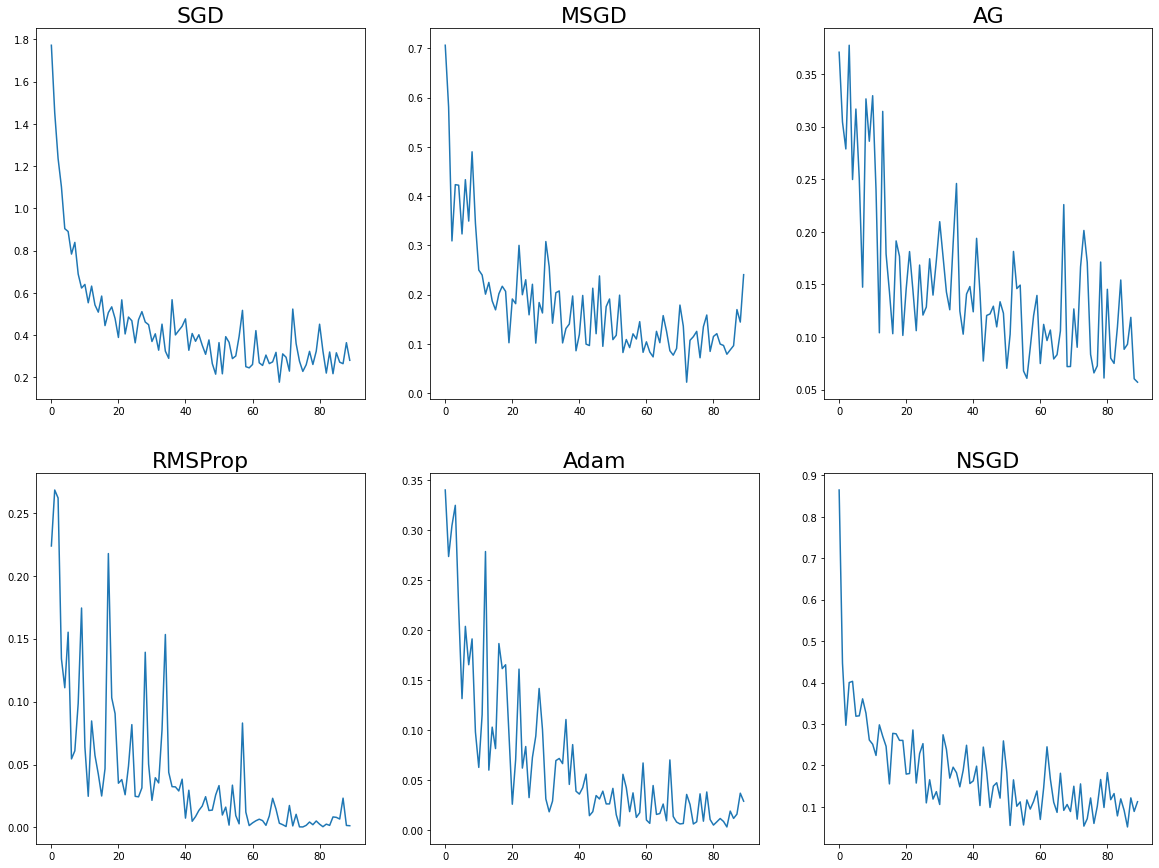

In [44]:
import numpy as np
plt.figure(figsize=(20, 15))
function_of_paint(1000, 9, 'Batch', True, 'None', 'SGD', 1)
function_of_paint(1000, 9, 'Batch', True, 'None', 'MSGD', 2)
function_of_paint(1000, 9, 'Batch', False, 'None', 'AG', 3)
function_of_paint(1000, 9, 'None', False, 'Xavier', 'RMSProp', 4)
function_of_paint(500, 9, 'None', False, 'Kaiming', 'Adam', 5)
function_of_paint(1000, 9, 'Batch', False, 'None', 'NSGD', 6)
plt.show()

# Графики процесса обучения

**Замечание**. Напомним, что в этом случае тестовый набор MNIST играет роль валидационного набора, так как подбор оптимальных значений гиперапараметров на тестовых данных может приводить к переобучению!

In [ ]:
# Ваш код

#### Задания (факультативные).
1. Прочитать параграф 3.6 в учебнике С. Николенко и др. (стр. 123–135) и воспроизвести рассмотренные там нейронные сети на TensorFlow.
1. Воспроизвести пример на Keras на стр. 147–149.
1. Воспроизвести пример на TensorFlow на стр. 158–159.